**Imports**

In [15]:
# Imports und Funktions-Imports
# Standard- und externe Bibliotheken
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

# Eigene Funktions-Module für Daten, Berechnung und Steuerung
from functions.retro_data.weather_data import get_weather
from functions.retro_data.spotprice_data import get_spotprice
from functions.retro_data.consumption_data import get_demand

from functions.forecast.spotprice_forecast_data import get_spotprice_forecast
from functions.forecast.weather_forecast_data import get_weather_forecast
from functions.forecast.weather_real_data import get_weather_real
from functions.forecast.consumption_forecast_data import get_demand_forecast

from functions.calculations.calculations import calculate_energy
from functions.calculations.kpis import calculate_kpis
from functions.calculations.kpis_valid import calculate_kpis_valid
from functions.deciding_functions.optimized import optimize_energy_flow
from functions.deciding_functions.optimized_valid import optimize_energy_flow_valid
from functions.deciding_functions.rulebased import rule_based_energy_flow
from functions.results.results import get_results

**Definition des Green Energy Ecosystems**

In [16]:
# Systemparameter und Annahmen
# Hier werden alle relevanten Systemparameter für PV, Wind, Batterie, Verbraucher etc. gesetzt.
# Werte können für Szenarien einfach angepasst werden.

# Photovoltaik
solar_peak_power = 38  # Spitzenleistung Gesamtsystem PV [MW]
num_modules = 114980 #Anzahl Solarmodule
area_per_module = 1.57458  # Fläche pro Modul [m²] (Annahme Heckert Solar NeMo® 2.0 330 Wp)
module_efficiency = 0.196  # Wirkungsgrad der Solarmodule (Annahme Heckert Solar NeMo® 2.0 330 Wp)
tilt_angle = 45  # Neigungswinkel der Solarpanels [°] (Annahme)
latitude=51.751111 # Breitengrad
longitude=4.208611 # Längengrad
azimuth=180 # Azimut [°]
albedo=0.2 # Albedo

# Windkraft 
wind_peak_power = 22   # Spitzenleistung Gesamtsystem Windkraft [MW]
r = 60 # Rotor Radius [m]
h = 90 # Höhe Windrad [m]
turbine_efficiency = 0.5  # Wirkungsgrad der Windkraftanlagen (Annahme)
cut_in = 2.5  # Einschaltgeschwindigkeit [m/s]
cut_out = 28  # Abschaltgeschwindigkeit [m/s]
num_turbines = 6 # Anzahl Windkraftanlagen

# Batteriespeicher
battery_capacity = 12  # [MWh]
soc = 0.5  # State of Charge (SOC) initial [0-1]
initial_battery = soc * battery_capacity  # [MWh]
charging_rate = 10  # Lade-/Entladerate [MW]
discharging_rate = 10

# Verbraucher
yearly_demand = 2.7  #  Verbrauch eines Haushalts/Jahr [MWh] (Annahme)
num_houses = 39000  # Anzahl Haushalte

# Strompreis
export_factor = 0.25   # Anteil vom Spotpreis für Einspeisung
price_low_quant  = 0.30   # Regelbasiert: Niedrigpreis-Schwelle

# Parameter für Sliding Window
forecast_horizon = 48   # Länge des Fensters [Tage] (2)
stepsize = 1    # Schrittweite [Stunden] (1)

**Vorbereiten der Datensätze**

In [17]:
df_weather_forecast = get_weather_forecast()
df_weather_real = get_weather_real()
df_spot_forecast, df_spot_real = get_spotprice_forecast()
df_demand_real = get_demand_forecast(num_houses, yearly_demand)

c:\Users\Julian\Documents\01_Hochschule\Master\02_Semester\Forschungsseminar\Code\functions\forecast\spotprice_forecast_data.py:13: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt_local_naive = pd.to_datetime(


In [18]:
display(df_spot_real)

,datetime,spotprice
0,2025-08-20 00:00:00,97.7
1,2025-08-20 01:00:00,93.2
2,2025-08-20 02:00:00,87.6
3,2025-08-20 03:00:00,85.8
4,2025-08-20 04:00:00,89.7
...,...,...
80,2025-08-23 08:00:00,83.6
81,2025-08-23 09:00:00,62.9
82,2025-08-23 10:00:00,14.7
83,2025-08-23 11:00:00,3.3


**Ausführen der Berechnungsfunktion**

In [19]:
# Energie- und Bedarfsberechnung für Trainings- und Testdaten
# Berechnet PV-/Wind-Ertrag und merged alle relevanten Spalten.

df_energy_forecast = calculate_energy(
    df_weather_forecast, 
    solar_peak_power, num_modules, area_per_module, module_efficiency, tilt_angle, latitude, longitude, azimuth, albedo, 
    wind_peak_power, r, h, turbine_efficiency, cut_in, cut_out, num_turbines
)

df_forecast = df_energy_forecast.merge(
    df_spot_forecast[['datetime', 'spotprice']],
    on='datetime', how='left'
 ).merge(
    df_demand_real[['datetime', 'energy_demand']],
    on='datetime', how='left'
 ).reset_index(drop=True)

df_energy_real = calculate_energy(
    df_weather_real, 
    solar_peak_power, num_modules, area_per_module, module_efficiency, tilt_angle, latitude, longitude, azimuth, albedo, 
    wind_peak_power, r, h, turbine_efficiency, cut_in, cut_out, num_turbines
)

df_real = df_energy_real.merge(
    df_spot_real[['datetime', 'spotprice']],
    on='datetime', how='left'
 ).merge(
    df_demand_real[['datetime', 'energy_demand']],
    on='datetime', how='left'
 ).reset_index(drop=True)

# Optional: Daten anzeigen
# display(df_train.head()), display(df_test.head())

In [29]:
df_real.to_csv('df_real.csv', index=False)
df_forecast.to_csv('df_forecast.csv', index=False)

In [20]:
"""df_real = df_real.iloc[:24].reset_index(drop=True)
df_forecast = df_forecast.iloc[: 24].reset_index(drop = True)

print(len(df_forecast), len(df_real))"""

'df_real = df_real.iloc[:24].reset_index(drop=True)\ndf_forecast = df_forecast.iloc[: 24].reset_index(drop = True)\n\nprint(len(df_forecast), len(df_real))'

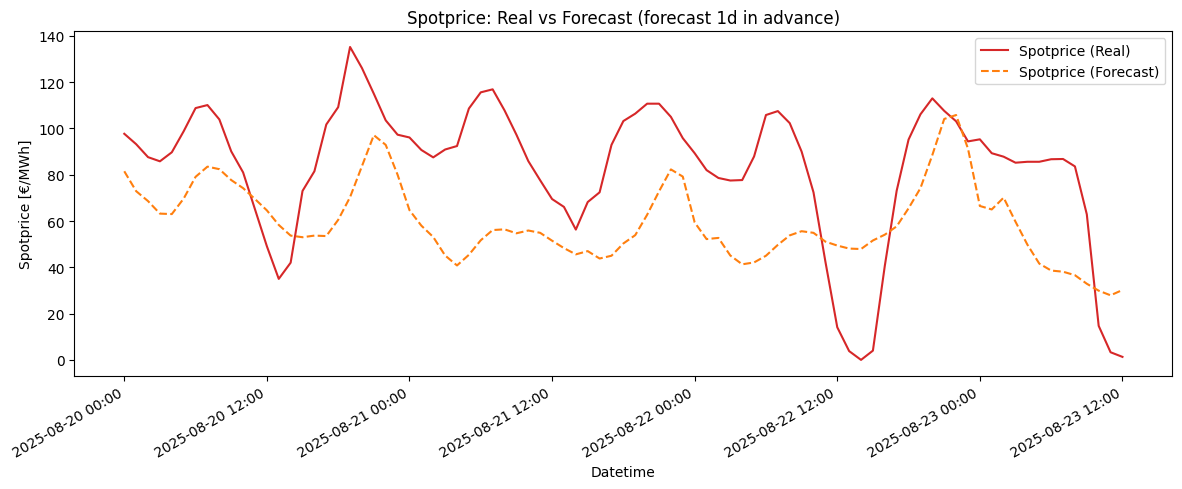

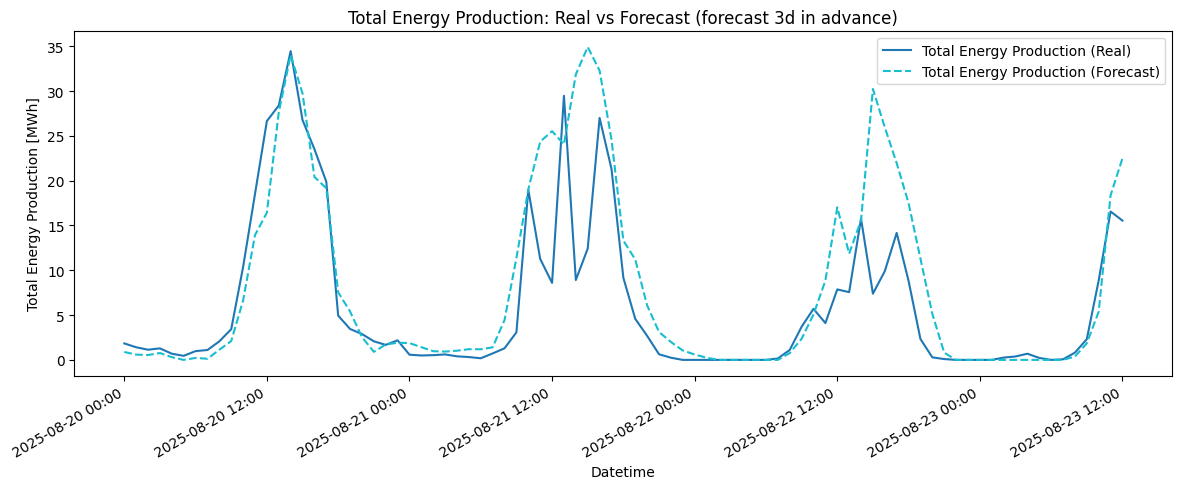

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.api.types import is_datetime64_any_dtype as is_datetime

# Sicherstellen, dass die Datetime-Spalte im richtigen Format ist
for df in [df_real, df_forecast]:
    if not is_datetime(df['datetime']):
        df['datetime'] = pd.to_datetime(df['datetime'])

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_real['datetime'], df_real['spotprice'], label='Spotprice (Real)', color='tab:red')
ax.plot(df_forecast['datetime'], df_forecast['spotprice'], label='Spotprice (Forecast)', color='tab:orange', linestyle='--')
ax.set_xlabel('Datetime')
ax.set_ylabel('Spotprice [€/MWh]')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.autofmt_xdate()
ax.legend()
plt.title('Spotprice: Real vs Forecast (forecast 1d in advance)')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_real['datetime'], df_real['total_energy_production'], label='Total Energy Production (Real)', color='tab:blue')
ax.plot(df_forecast['datetime'], df_forecast['total_energy_production'], label='Total Energy Production (Forecast)', color='tab:cyan', linestyle='--')
ax.set_xlabel('Datetime')
ax.set_ylabel('Total Energy Production [MWh]')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.autofmt_xdate()
ax.legend()
plt.title('Total Energy Production: Real vs Forecast (forecast 3d in advance)')
plt.tight_layout()
plt.show()

In [22]:
df_diff = pd.DataFrame()

df_diff['difference'] = df_forecast['total_energy_production'] - df_real['total_energy_production']

df_diff['price_penalty'] = df_diff['difference'] * df_real['spotprice']

summe = df_diff['price_penalty'].sum()

print("Summe der Preisstrafe:", summe, "€")

Summe der Preisstrafe: 16580.82857291302 €


**Ausführen der Entscheidungs-Funktionen**

In [23]:
result_df_rule_real = rule_based_energy_flow(
    df_real, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, price_low_quant
    )

result_kpis_rule_real = calculate_kpis(result_df_rule_real, export_factor)

In [24]:
forecast_horizon = 1

result_df_opt_noforecast = optimize_energy_flow(
    df_real, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, 
    forecast_horizon, stepsize
    )

result_kpis_opt_noforecast = calculate_kpis_valid(result_df_opt_noforecast,df_spot_real, export_factor)

In [25]:
forecast_horizon = 24

result_df_opt_forecast = optimize_energy_flow_valid(
    df_forecast, df_real, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, 
    forecast_horizon, stepsize
    )

result_df_opt_real = optimize_energy_flow_valid(
    df_real, df_real,
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, 
    forecast_horizon, stepsize
    )

result_kpis_opt_forecast = calculate_kpis_valid(result_df_opt_forecast, df_spot_real, export_factor)
result_kpis_opt_real = calculate_kpis_valid(result_df_opt_real, df_spot_real, export_factor)

In [26]:
print(result_kpis_rule_real)
#print(result_kpis_opt_noforecast)
print(result_kpis_opt_real)
print(result_kpis_opt_forecast)

{'Netto Stromkosten': 55128.479242327194, 'Netzstromkosten': 56783.55675461183, 'Einspeisevergütung': 1655.0775122846394, 'Netzbezug': 623.9423878465515, 'Einspeisung': 109.62055384231736, 'Batterieladung': 80.16702019045181, 'Batterieentladung': 74.16702019045181}
{'Netto Stromkosten': 51198.0817280459, 'Netzstromkosten': 52887.592427005904, 'Einspeisevergütung': 1689.51069896, 'Netzbezug': 596.369787663, 'Einspeisung': 105.3502986, 'Batterieladung': 104.5810257, 'Batterieentladung': 110.5810257}
{'Netto Stromkosten': 45607.365711258244, 'Netzstromkosten': 48499.42899582844, 'Einspeisevergütung': 2892.063284570195, 'Netzbezug': 521.709257005698, 'Einspeisung': 194.86351418693, 'Batterieladung': 106.2986593, 'Batterieentladung': 112.2986593}


In [27]:
# Berechnung des absoluten und relativen Fehlers der Netto-Stromkosten
netto_opt_real = result_kpis_opt_real['Netto Stromkosten']
netto_opt_forecast = result_kpis_opt_forecast['Netto Stromkosten']

abs_error_nettostromkosten = abs(netto_opt_real - netto_opt_forecast + summe)
rel_error_nettostromkosten = abs_error_nettostromkosten / netto_opt_real

print("Netto Stromkosten: abs. Fehler (EUR):", abs_error_nettostromkosten)
print("Netto Stromkosten: rel. Fehler (%):", rel_error_nettostromkosten * 100)

Netto Stromkosten: abs. Fehler (EUR): 22171.544589700676
Netto Stromkosten: rel. Fehler (%): 43.30542051843181


In [28]:
import numpy as np
from sklearn.metrics import r2_score

mean_real_spotprice = df_real['spotprice'].mean()
mean_forecast_spotprice = df_forecast['spotprice'].mean()
mean_real_energy = df_real['total_energy_production'].mean()
mean_forecast_energy = df_forecast['total_energy_production'].mean()

# Mittelwerte berechnen
mean_abs_error_spotprice = abs(mean_forecast_spotprice - mean_real_spotprice)
mean_rel_error_spotprice = abs(mean_forecast_spotprice - mean_real_spotprice) / mean_real_spotprice

mean_abs_error_total_energy = abs(mean_forecast_energy - mean_real_energy)
mean_rel_error_total_energy = abs(mean_forecast_energy - mean_real_energy) / mean_real_energy
print(" ")
print("Spotprice: abs. Fehler (€/MWh):", mean_abs_error_spotprice)
print("Spotprice: rel. Fehler (%):", mean_rel_error_spotprice * 100)
print("Total Energy Production: abs. Fehler (MWh):", mean_abs_error_total_energy)
print("Total Energy Production: rel. Fehler (%):", mean_rel_error_total_energy * 100)



 
Spotprice: abs. Fehler (€/MWh): 23.595910364145645
Spotprice: rel. Fehler (%): 28.410877681730323
Total Energy Production: abs. Fehler (MWh): 2.2567138442060797
Total Energy Production: rel. Fehler (%): 37.9326776913161
